In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries

import math
import os
import sys

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keras
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv1D, Dropout, Activation, Flatten
from keras.metrics import AUC
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import Sequence

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

# Local imports
from models import Attia_et_al_CNN

from utils import split_train_val_test

# Environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/tmp/ipykernel_776882/440860501.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-23 12:58:45.567475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 12:58:45.567502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 12:58:45.568424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

In [3]:
data_df = pd.read_pickle('data/ptb-xl_dataset.pickle')

In [4]:
from utils import mapping


In [5]:
mapping

{'1AVB': '1AVB',
 'AF': 'AFLT',
 'AFIB': 'AFIB',
 'APB': 'PAC',
 'AQW': 'ABQRS',
 'IDC': 'IVCD',
 'LVH': 'LVH',
 'LVQRSAL': 'LVOLT',
 'RBBB': 'CRBBB',
 'SR': 'SR',
 'ST': 'STACH',
 'STDD': 'STD_',
 'STE': 'STE_',
 'STTC': 'NST_',
 'SVT': 'SVTAC',
 'TWC': 'NT_',
 'TWO': 'INVT'}

In [6]:
conditions = [mapping[key] for key in mapping.keys()]
conditions

['1AVB',
 'AFLT',
 'AFIB',
 'PAC',
 'ABQRS',
 'IVCD',
 'LVH',
 'LVOLT',
 'CRBBB',
 'SR',
 'STACH',
 'STD_',
 'STE_',
 'NST_',
 'SVTAC',
 'NT_',
 'INVT']

In [7]:
from utils import mapping

conditions = [mapping[key] for key in mapping.keys()]

X, y = data_df['wf'].to_numpy(), data_df[conditions].to_numpy()
y = y.astype(float)
X = np.stack(X, axis=0)

del data_df

single-lead

In [8]:
from sklearn.metrics import roc_auc_score


lead_labels = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

df = pd.DataFrame(columns=['baseline'] + lead_labels, index=conditions + ['Avg'], dtype=float)

for lead in lead_labels:
    print(f"Lead: {lead}")
    lead_idx = lead_labels.index(lead)
    X_test_lead = X[:, :, lead_idx].copy()
    X_test_lead = X_test_lead.reshape(-1, 5000, 1)

    model_path = f"models/single-lead/mult_output_cnn_{lead}.keras"
    model = keras.saving.load_model(model_path)
    y_pred = model.predict(X_test_lead, verbose=0)

    for i, condition in enumerate(conditions):
        auc = roc_auc_score(y[:,i], y_pred[:,i])
        # print(f"{condition}: {auc}")

        df.loc[condition, lead] = auc

Lead: I


2024-04-23 12:59:13.949309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 12:59:13.981358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 12:59:13.981703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Lead: II
Lead: III
Lead: aVR
Lead: aVF
Lead: aVL
Lead: V1
Lead: V2
Lead: V3
Lead: V4
Lead: V5
Lead: V6


In [9]:
model_path = f"models/12-lead/multi_output_cnn.keras"
model = keras.saving.load_model(model_path)
pred = model.predict(X, verbose=1)

for i, condition in enumerate(conditions):
    auc = roc_auc_score(y[:,i], pred[:,i])
    print(f"{condition}: {auc}")

    df.loc[condition, 'baseline'] = auc

682/682 [==============================] - 2s 3ms/step
1AVB: 0.9524081812210261
AFLT: 0.9421298135306602
AFIB: 0.9891671814034423
PAC: 0.7078151023328407
ABQRS: 0.6804179890687934
IVCD: 0.6469074306422832
LVH: 0.7928518748990581
LVOLT: 0.6149980148916172
CRBBB: 0.8689235445383701
SR: 0.7934914540424238
STACH: 0.9911484834242666
STD_: 0.7930517120804534
STE_: 0.4716136144412292
NST_: 0.7677709585641646
SVTAC: 0.9830107987833507
NT_: 0.7334850467504707
INVT: 0.8875349349225857


In [14]:
condition_mapping

NameError: name 'condition_mapping' is not defined

In [26]:

condition_mapping = {
    mapping['1AVB']: '1st degree atrioventricular block',
    mapping['AF']: 'Atrial flutter',
    mapping['AFIB']: 'Atrial fibrillation',
    mapping['APB']: 'Atrial premature beat',
    mapping['AQW']: 'Abnormal Q wave',
    # 'ARS': 'Axis right shift',
    mapping['IDC']: 'Interior differences conduction',
    mapping['LVH']: 'Left ventricular hypertrophy',
    mapping['LVQRSAL']: 'Lower voltage QRS in all lead',
    mapping['RBBB']: 'Right bundle branch block',
    # 'SA': 'Sinus Irregularity',
    # mapping['SB']: 'Sinus bradycardia',
    mapping['ST']: 'Sinus tachycardia',
    mapping['STDD']: 'ST depression',
    mapping['STE']: 'ST extension',
    mapping['STTC']: 'ST-T wave change',
    mapping['SVT']: 'Supraventricular tachycardia',
    mapping['TWC']: 'T wave change',
    mapping['TWO']: 'T wave inversion',
    mapping['SR']: 'Sinus rhythm',
    'Avg': 'Avg'
}


In [27]:
condition_mapping

{'1AVB': '1st degree atrioventricular block',
 'AFLT': 'Atrial flutter',
 'AFIB': 'Atrial fibrillation',
 'PAC': 'Atrial premature beat',
 'ABQRS': 'Abnormal Q wave',
 'IVCD': 'Interior differences conduction',
 'LVH': 'Left ventricular hypertrophy',
 'LVOLT': 'Lower voltage QRS in all lead',
 'CRBBB': 'Right bundle branch block',
 'STACH': 'Sinus tachycardia',
 'STD_': 'ST depression',
 'STE_': 'ST extension',
 'NST_': 'ST-T wave change',
 'SVTAC': 'Supraventricular tachycardia',
 'NT_': 'T wave change',
 'INVT': 'T wave inversion',
 'SR': 'Sinus rhythm',
 'Avg': 'Avg'}

In [21]:
inv_mapping = {v: k for k, v in mapping.items()}

In [28]:
# conditions = ['1AVB', 'AF', 'AFIB', 'APB', 'AQW', 'IDC',
#               'LVH', 'LVQRSAL', 'RBBB', 'SR', 'ST',
#               'STDD', 'STE', 'STTC', 'SVT', 'TWC',
#               'TWO']

df.index = [condition_mapping[i] for i in df.index]

df.loc['Avg'] = df.mean(axis=0)

In [29]:
df.to_pickle('cnn_perf_PTB-XL.pickle')

In [30]:
# Drop sinus rhythm index
df = df.drop('Sinus rhythm')
df = df.drop('ST extension')


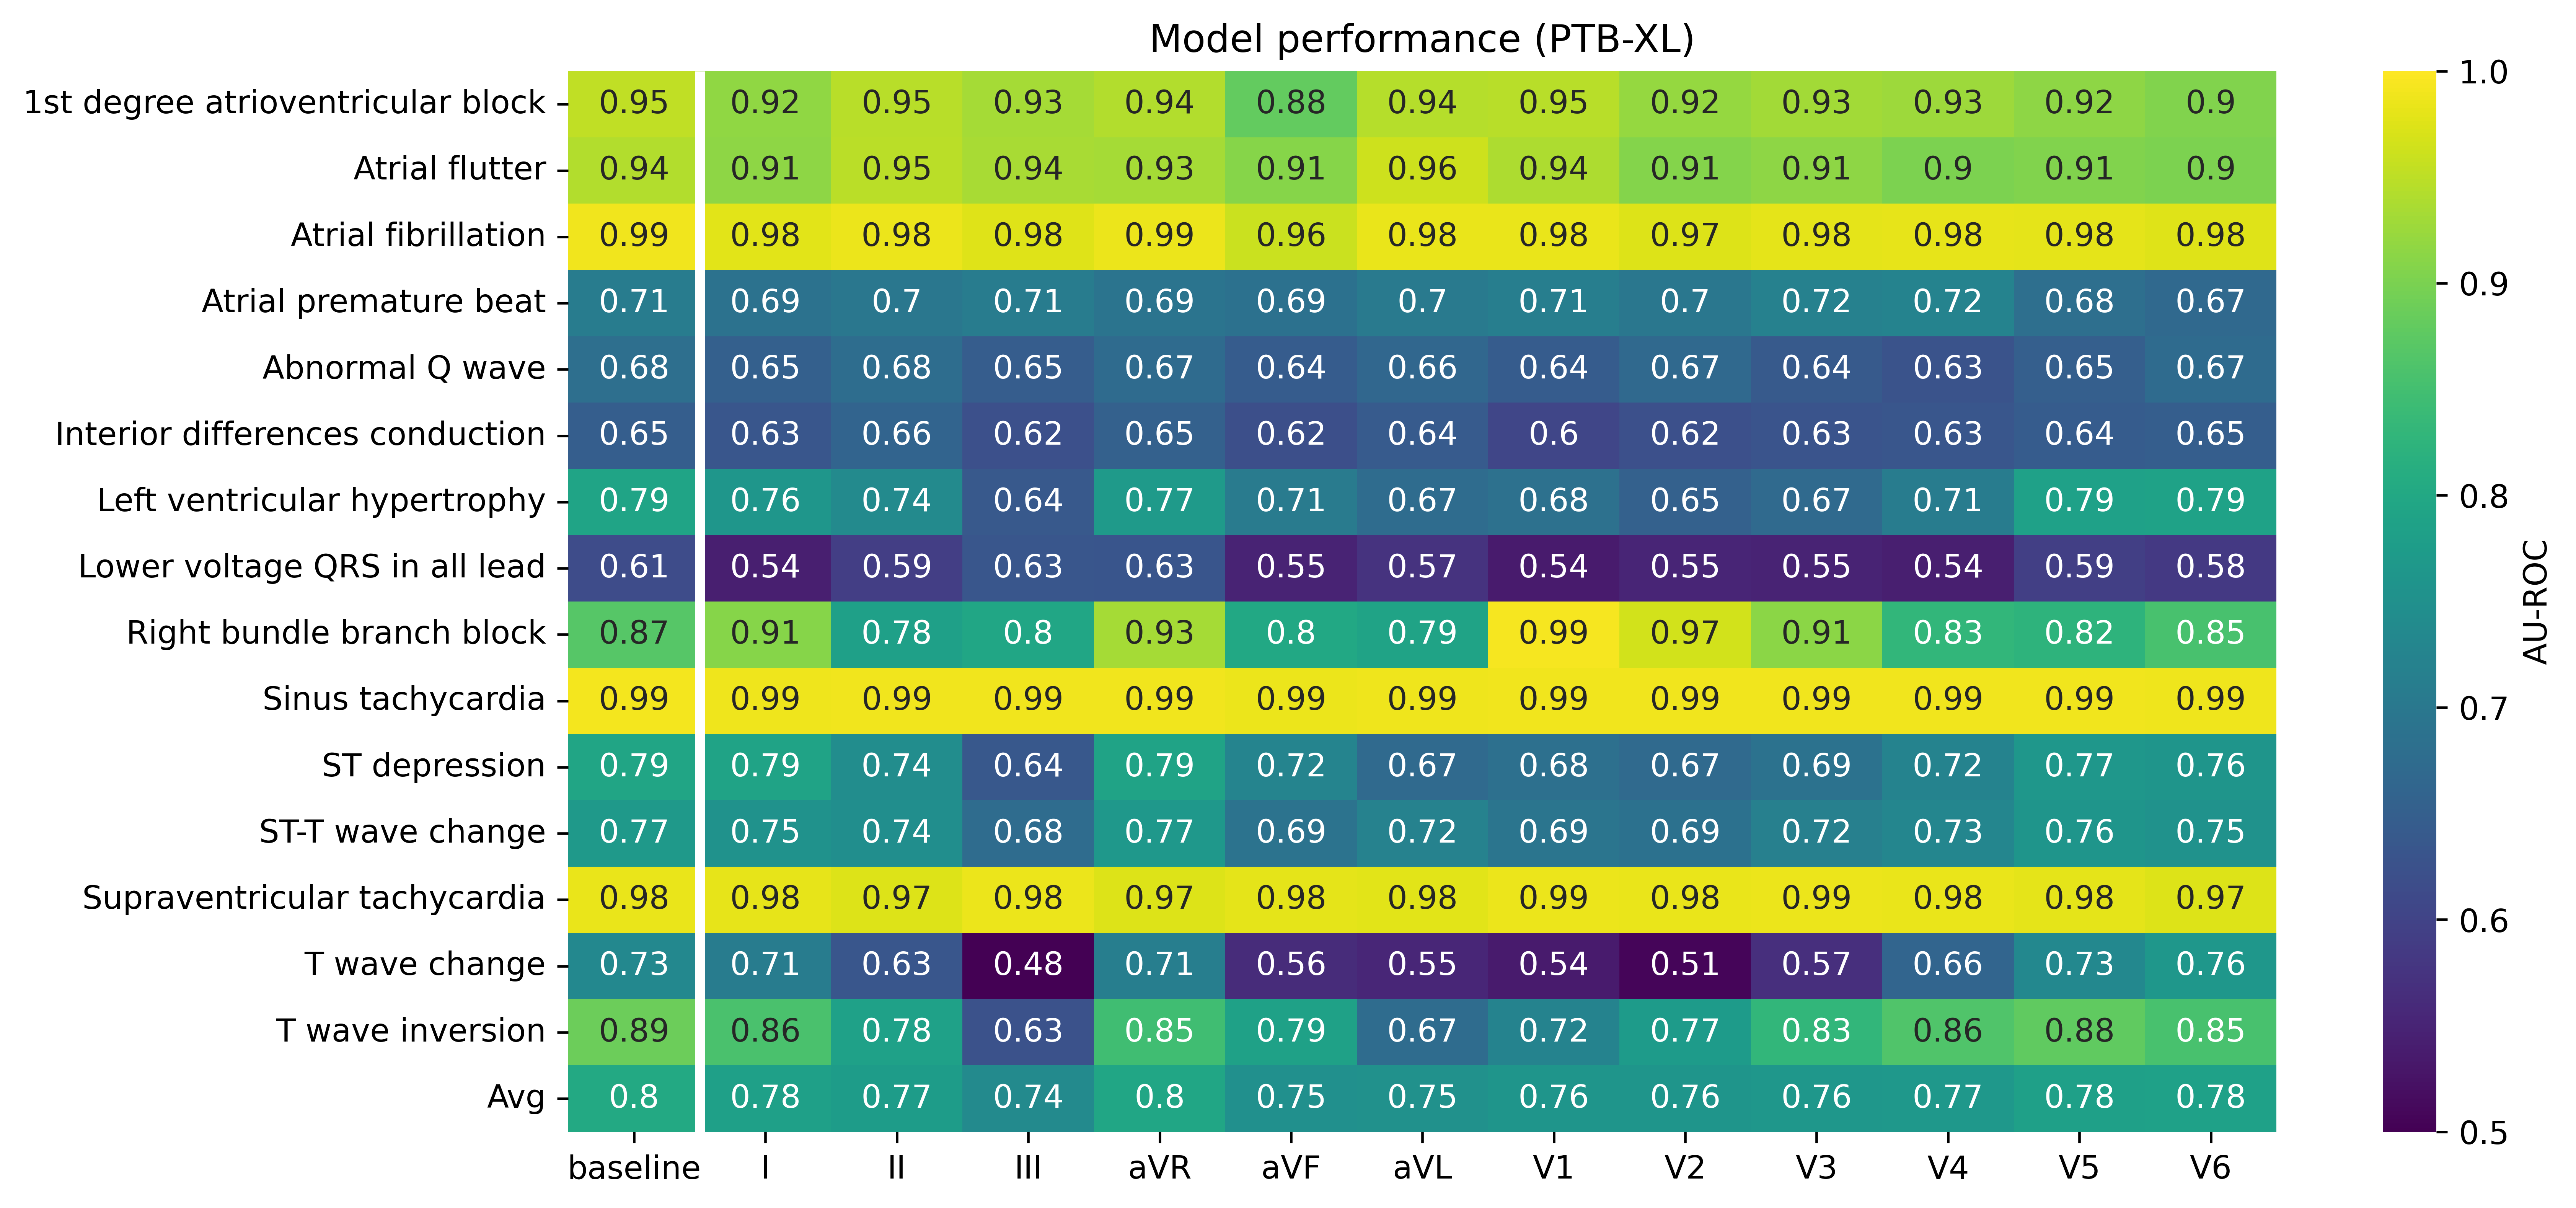

In [31]:
# Create a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize = (12, 6), dpi=600)

sns.heatmap(df, annot=True, cmap="viridis", cbar_kws={'label': 'AU-ROC'}, vmin=0.5, vmax=1)
plt.title('Model performance (PTB-XL)')
b, t = plt.ylim()
ax.vlines(x = 1, ymin = b, ymax = t, colors = 'white', lw = 3)

b, t = plt.xlim()
ax.hlines(y = 17, xmin = b, xmax = t, colors = 'white', lw = 3)

# Save model as pdf

plt.savefig('cnn_perf_PTB-XL.pdf', bbox_inches = "tight")
plt.savefig('cnn_perf_PTB-XL.png', bbox_inches = "tight", dpi=600)
plt.show()

In [32]:
internal_df = pd.read_pickle('cnn_perf_internal.pickle')

internal_df = internal_df.drop('Sinus rhythm')
internal_df = internal_df.drop('ST extension')

In [33]:
diff_df = df - internal_df

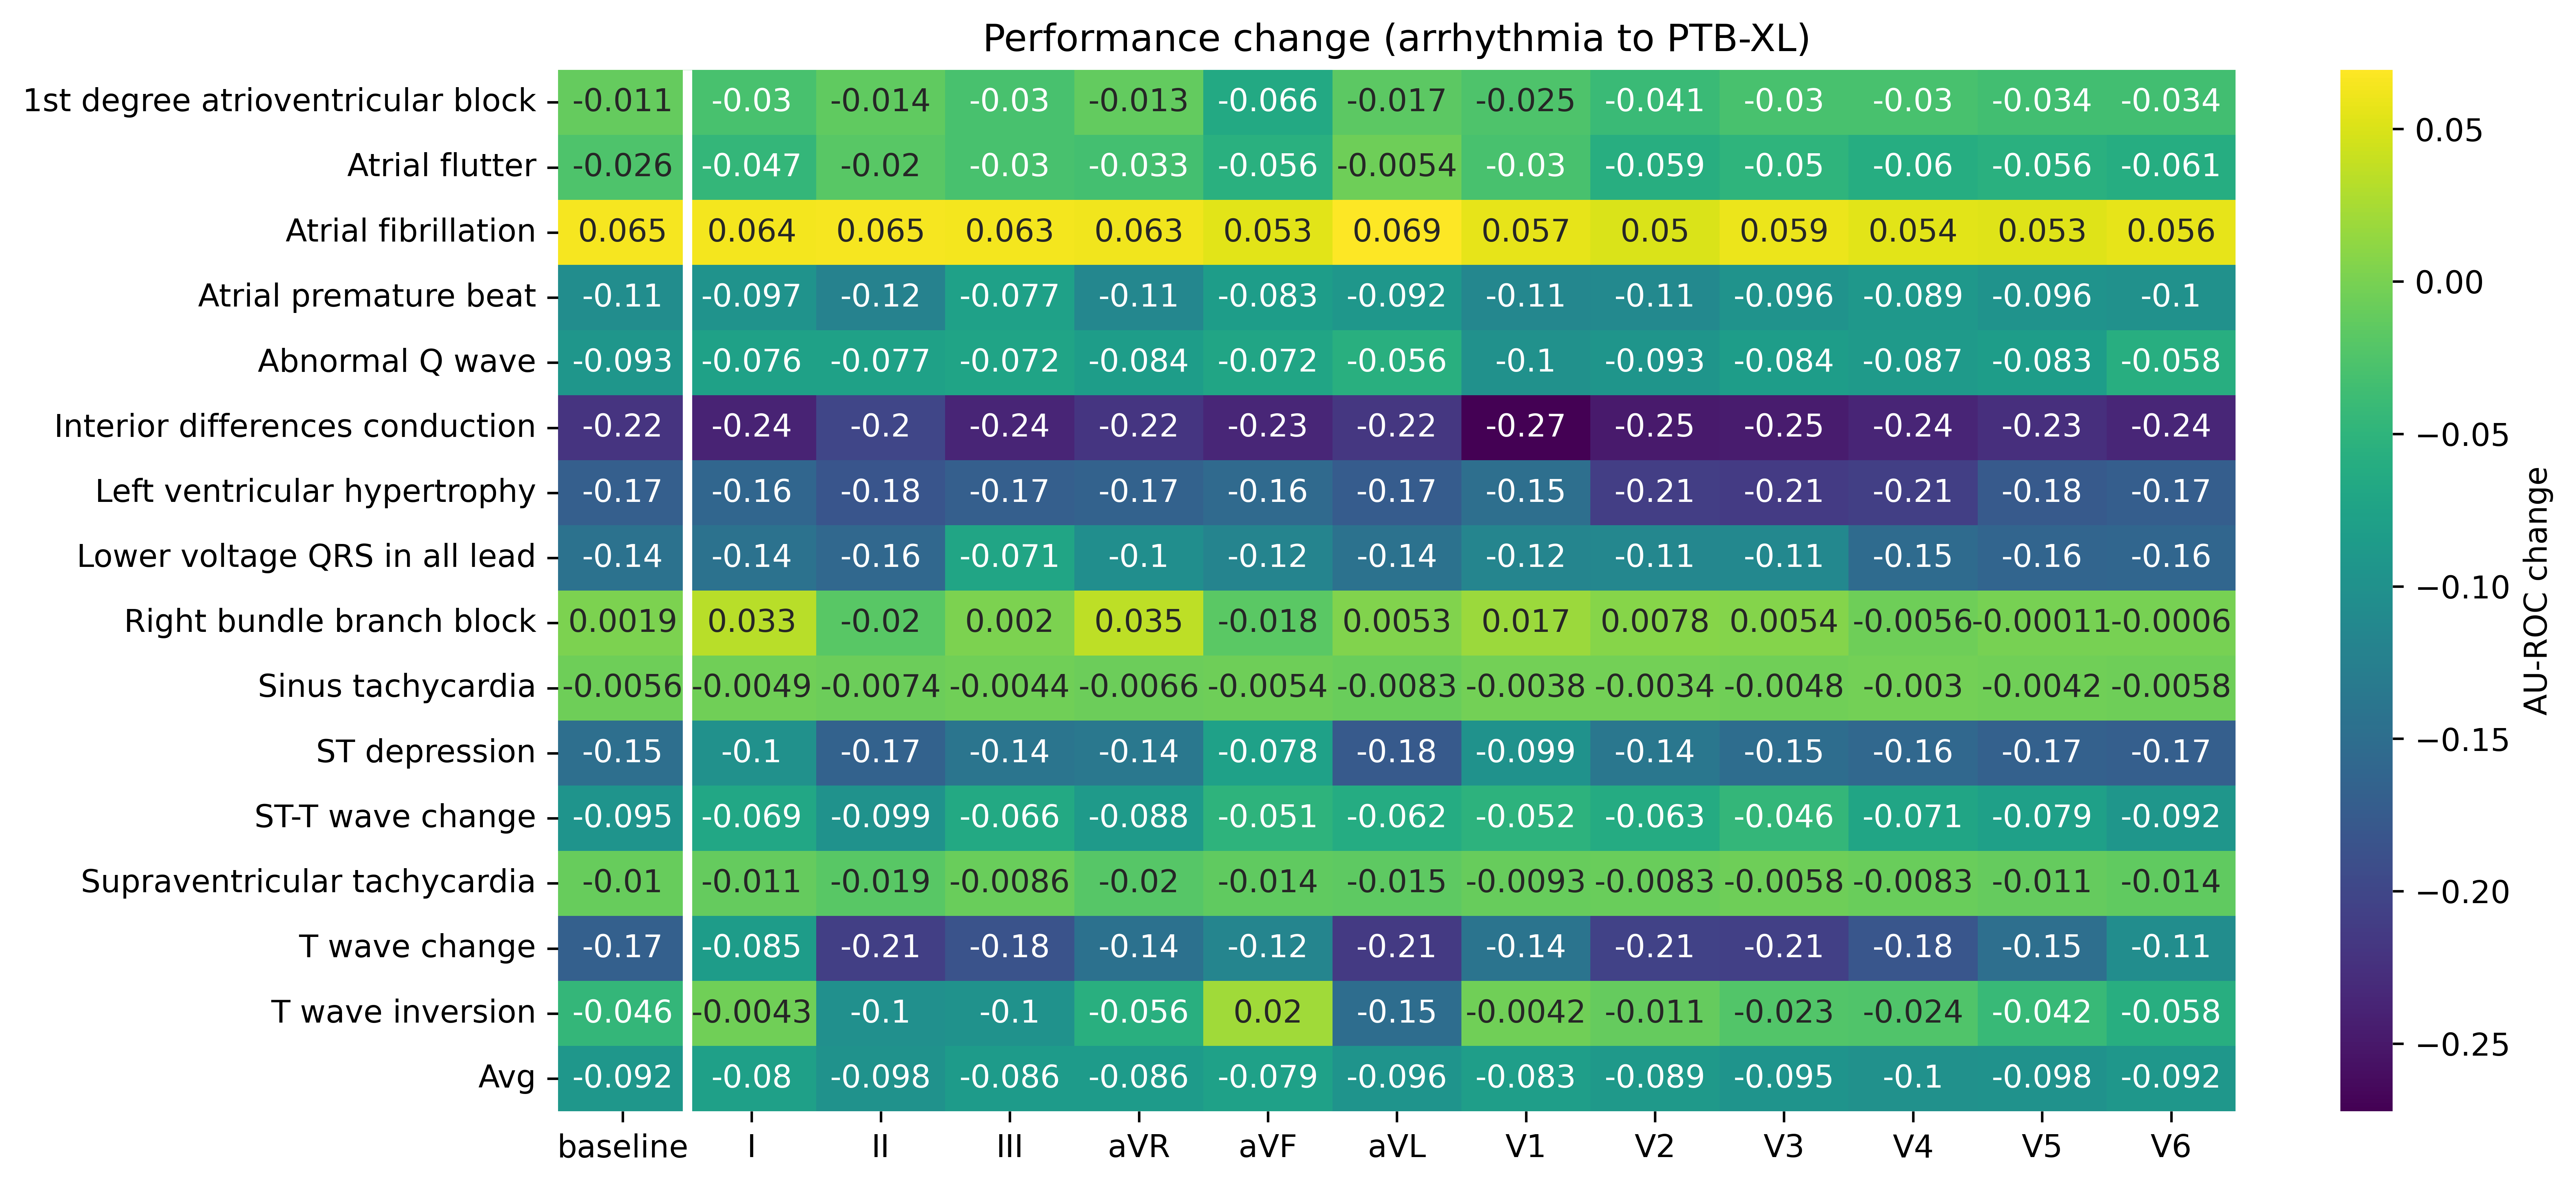

In [34]:
# Create a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize = (12, 6), dpi=600)

sns.heatmap(diff_df, annot=True, cmap="viridis", cbar_kws={'label': 'AU-ROC change'})
plt.title('Performance change (arrhythmia to PTB-XL)')
b, t = plt.ylim()
ax.vlines(x = 1, ymin = b, ymax = t, colors = 'white', lw = 3)

b, t = plt.xlim()
ax.hlines(y = 17, xmin = b, xmax = t, colors = 'white', lw = 3)

plt.savefig('cnn_perf_diff.pdf', bbox_inches = "tight")
plt.savefig('cnn_perf_diff.png', bbox_inches = "tight", dpi=600)
plt.show()